In [75]:
import pymc as pm
import numpy as np
import scipy.io as sio
import glob
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import math
from itertools import cycle


%matplotlib inline

color_cycle = cycle(['g', 'b', 'c', 'm', 'y', 'k'])

In [3]:
def load_RDK_data_from_mat_to_pandas(filename):
    mat = sio.loadmat(filename)
    mat = mat['temp_obj'][0]
    field_names = mat.dtype.names
    data = mat[0]
    data_dict = dict(zip(field_names,data))
    for key in data_dict:
        data_dict[key] = data_dict[key].squeeze()

    return data_dict

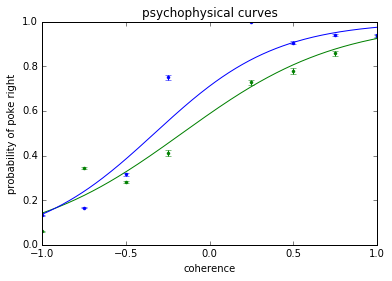

In [210]:
rat_name = 'rosa0'
folder = '20170823'
file1 = glob.glob('/home/adam/Documents/DATA/RDK/Behavior_1/Box*/' + folder + '/'+rat_name+'_session1.spd')
data = load_RDK_data_from_mat_to_pandas(file1[0])
data = pd.DataFrame.from_dict(data)
data.index.name = 'trial'

# this makes psychophysical curves
data = data[200:600]
plt.figure()
plt.title('psychophysical curves')
plt.xlabel('coherence')
plt.ylabel('probability of poke right')
for p in data.prior_right.unique():
    cc = color_cycle.next()
    
    data_p = data.loc[lambda x: x.prior_right == p] # pick out data for the given prior
    coherence_means = data_p.groupby(['coherence'],as_index=False).response_right.mean()
    
    # std of estimation for a binary variable is sqrt(p(1-p)/n)
    yerrors = np.ravel(coherence_means.apply(lambda x: x*(1-x)).response_right)
    yerrors = yerrors/np.ravel(data_p['coherence'].value_counts())
    plt.errorbar(coherence_means.coherence,coherence_means.response_right,yerr = yerrors,fmt='.',color=cc)
    
    # logistic regression to fit psychophysical curve
    log_model = linear_model.LogisticRegression(C=1e20,max_iter=100,penalty='l2')
    log_model.fit(X = data_p.coherence.reshape(data_p.coherence.count(),1), y = np.ravel(data_p.response_right))
    
    # plot values psych curves
    x_val = np.linspace(-1,1,200).reshape(200,1)
    plt.plot(x_val,log_model.predict_proba(x_val)[:,1],color=cc)

In [114]:
# this runs mcmc on the data

response_data = np.ravel(data.response_right)
coherences = np.ravel(data.coherence)
unique_coherences = np.unique(coherences);


slope_ = pm.Uniform('a',-10,10,value=1)
intercept_ = pm.Uniform('b',-1,1,value=0)
offset1_ = pm.Uniform('c',0,1,value=0.85)
print slope_.random()

@pm.deterministic
def coin_probs_over_time(s_ = slope_, i_ = intercept_, uc = unique_coherences,c = coherences,o1 = offset1_,o2 = offset2_):
    out = np.zeros(len(c))
    for k in range(uc.size):       
        out[np.where(c==uc[k])]=o1*(1/( 1+math.exp(-4*s_*(uc[k]- i_)) )-0.5)+0.5
    return out

observation = pm.Bernoulli("obs",coin_probs_over_time,value=response_data,observed=True)



M = pm.Model([slope_,intercept_, coin_probs_over_time,observation,offset1_])
mcmc = pm.MCMC(M)
mcmc.sample(40000,10000,10)
    
    
    

-8.23357161553
 [-----------------100%-----------------] 40000 of 40000 complete in 31.2 sec

<Container object of 3 artists>

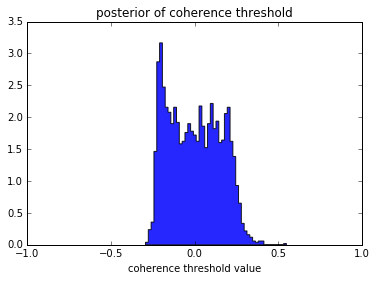

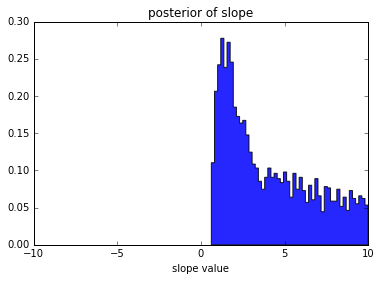

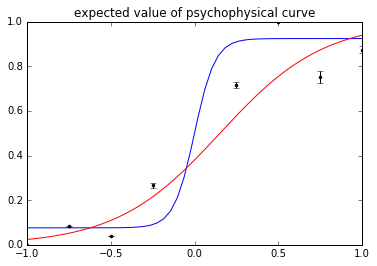

In [115]:
intercept_samples = mcmc.trace('b')[:]
slope_samples = mcmc.trace('a')[:]
o1_samples = mcmc.trace('c')[:]

plt.hist(intercept_samples,histtype='stepfilled',bins=50,alpha = 0.85,normed=True)
plt.xlabel('coherence threshold value')
plt.title('posterior of coherence threshold')
plt.xlim([-1,1])
plt.figure()
plt.hist(slope_samples,histtype='stepfilled',bins=50,alpha = 0.85,normed=True)
plt.xlabel('slope value')
plt.title('posterior of slope')
plt.xlim([-10,10])

expected_i = sum(intercept_samples)/len(intercept_samples)
expected_s = sum(slope_samples)/len(slope_samples)
expected_o1 = sum(o1_samples)/len(o1_samples)

x_vals = np.linspace(-1,1)
plt.figure()
plt.plot(x_vals,expected_o1*(1/( 1+np.exp(-4*expected_s*(x_vals- expected_i)))-0.5)+0.5)
plt.title('expected value of psychophysical curve')
# plot values psych curves
x_val = np.linspace(-1,1,200).reshape(200,1)
plt.plot(x_val,log_model.predict_proba(x_val)[:,1],color='r')
plt.errorbar(coherence_means.coherence,coherence_means.response_right,yerr = yerrors,fmt='.',color=cc)

In [92]:
# this runs mcmc on the data with a shift in activity

response_data = np.ravel(data.response_right)
coherences = np.ravel(data.coherence)
unique_coherences = np.unique(coherences);

num_tau = 1

tau_tup = ()

ll, uu = 0, len(response_data)-num_tau
ll,uu = 30,len(response_data)-num_tau-30

for k in range(num_tau):
    tau_tup= tau_tup + (pm.DiscreteUniform('tau'+str(k),lower=ll,upper=uu,value=200),)
    ll,uu = tau_tup[k],uu+1
tau_tup  = tau_tup + (len(response_data),)
tau_tup = tau_tup + (10,)



slope_tup = ()
threshold_tup = ()
for k in range(num_tau+1):
    slope_tup = slope_tup + (pm.Uniform('slope'+str(k),-1,1),)
    threshold_tup = threshold_tup + (pm.Uniform('threshold'+str(k),-1,1),)


@pm.deterministic
def coin_probs_over_time(s_ = slope_tup, thresh_=threshold_tup,tau_ = tau_tup, uc = unique_coherences,c = coherences):
    out = np.zeros(len(c))
    
    for k in range(uc.size):
        ll,uu = 0,tau_tup[0]
        for r in range(num_tau+1):

            rr = range(ll,uu)
            these_c = np.ravel(np.where(c==uc[k]))
            
            these_c = list(set(these_c).intersection(set(rr)))
            out[these_c] = 1/( 1+math.exp(-4*s_[r]*(uc[k]- thresh_[r])) )

            
            ll,uu=uu,tau_tup[r+1]
            
    return out

observation = pm.Bernoulli("obs",coin_probs_over_time,value=response_data,observed=True)



M = pm.Model(list(tau_tup)[0:num_tau]+list(slope_tup)+list(threshold_tup)+[coin_probs_over_time,observation])
mcmc = pm.MCMC(M)
mcmc.sample(40000,10000,5)
    

 [-----------------100%-----------------] 40000 of 40000 complete in 227.1 sec

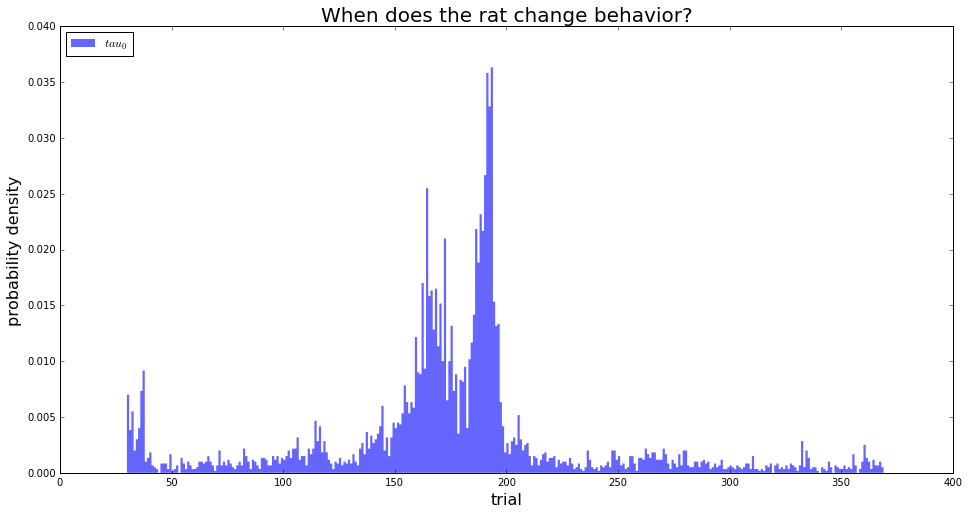

In [93]:
plt.figure(figsize=(16,8))
for i in range(1):
    to_plot = mcmc.trace('tau'+str(i))[:]
    plt.hist(to_plot,histtype='stepfilled',bins=range(0,400),alpha = 0.6,label='$ tau _'+str(i)+'$',linewidth = 0,normed = True)
plt.legend(loc='upper left')
plt.ylabel('probability density',fontsize=16)
plt.xlabel('trial',fontsize = 16)
plt.title('When does the rat change behavior?',fontsize=20)

Plotting tau0


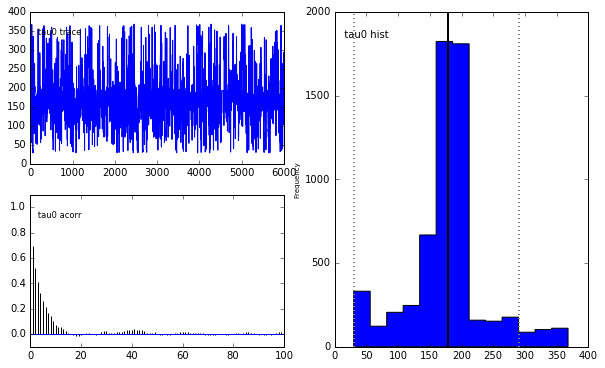

In [94]:
#mcmc.sample(25000,0,10)
pm.Matplot.plot(mcmc.trace('tau'+str(0)))

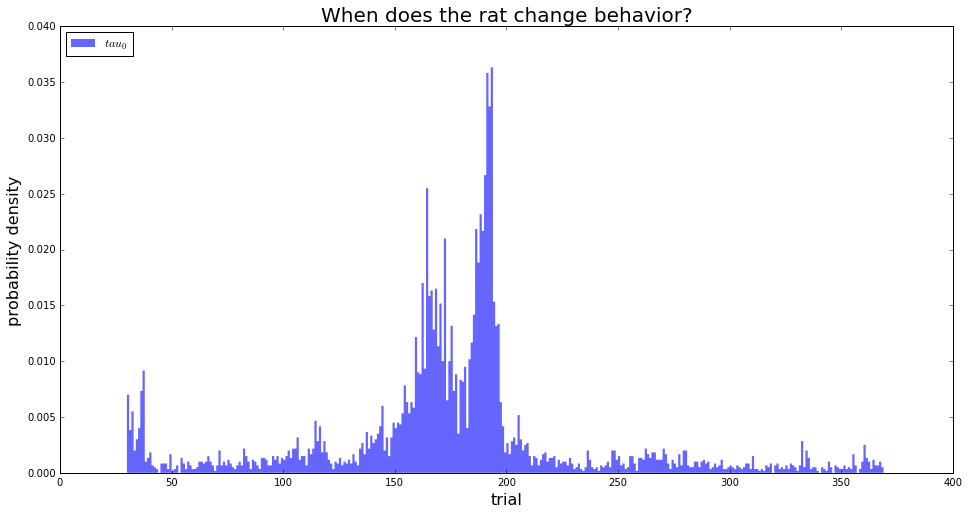

In [95]:
plt.figure(figsize=(16,8))
for i in range(1):
    to_plot = mcmc.trace('tau'+str(i))[:]
    plt.hist(to_plot,histtype='stepfilled',bins=range(0,400),alpha = 0.6,label='$ tau _'+str(i)+'$',linewidth = 0,normed = True)
plt.legend(loc='upper left')
plt.ylabel('probability density',fontsize=16)
plt.xlabel('trial',fontsize = 16)
plt.title('When does the rat change behavior?',fontsize=20)

In [6]:
def make_psych_curve_mcmc(data):
    
    # this runs mcmc on the data

    response_data = np.ravel(data.response_right)
    coherences = np.ravel(data.coherence)
    unique_coherences = np.unique(coherences);


    slope_ = pm.Uniform('a',-10,10,value=1)
    intercept_ = pm.Uniform('b',-1,1,value=0)
    offset1_ = pm.Uniform('c',0,1,value=0.85)

    @pm.deterministic
    def coin_probs_over_time(s_ = slope_, i_ = intercept_, uc = unique_coherences,c = coherences,o1 = offset1_):
        out = np.zeros(len(c))
        for k in range(uc.size):       
            out[np.where(c==uc[k])]=o1*(1/( 1+math.exp(-4*s_*(uc[k]- i_)) )-0.5)+0.5
        return out

    observation = pm.Bernoulli("obs",coin_probs_over_time,value=response_data,observed=True)



    M = pm.Model([slope_,intercept_, coin_probs_over_time,observation,offset1_])
    mcmc = pm.MCMC(M)
    mcmc.sample(10000,5000,2)
    
    intercept_samples = mcmc.trace('b')[:]
    slope_samples = mcmc.trace('a')[:]
    o1_samples = mcmc.trace('c')[:]
    
    e_i = sum(intercept_samples)/len(intercept_samples)
    e_s = sum(slope_samples)/len(slope_samples)
    e_o1 = sum(o1_samples)/len(o1_samples)
    
    
    x_vals = np.linspace(-1,1,200).reshape(200,1)
    #psych_f = lambda o1, s_, c, i_ : o1*(1/( 1+math.exp(-4*s_*(c- i_)) )-0.5)+0.5
    #y_vals = psych_f(expected_o1,expected_s,x_vals,expected_i)
    y_vals = e_o1*(1/( 1+np.exp(-4*e_s*(x_vals- e_i)) )-0.5)+0.5
    return x_vals,y_vals,e_i
    
    

 [-----------------100%-----------------] 10000 of 10000 complete in 4.8 sec(200, 1)
(200, 1)
-0.165939982896
 [-----------------100%-----------------] 10000 of 10000 complete in 4.7 sec(200, 1)
(200, 1)
-0.40810092253


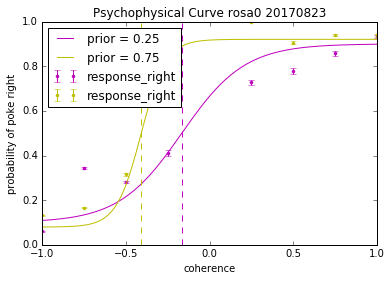

In [27]:
rat_name = 'rosa0'#'robin0'
folder = '20170823'
file1 = glob.glob('/home/adam/Documents/DATA/RDK/Behavior_1/Box*/' + folder + '/'+rat_name+'_session1.spd')
data = load_RDK_data_from_mat_to_pandas(file1[0])
data = pd.DataFrame.from_dict(data)
data.index.name = 'trial'

# this makes psychophysical curves
data = data[200:600]
data = data.reset_index()
plt.figure()
plt.title('psychophysical curves')
plt.xlabel('coherence')
plt.ylabel('probability of poke right')
for p in data.prior_right.unique():
    cc = color_cycle.next()
    
    data_p = data.loc[lambda x: x.prior_right == p] # pick out data for the given prior
    coherence_means = data_p.groupby(['coherence'],as_index=False).response_right.mean()
    
    # std of estimation for a binary variable is sqrt(p(1-p)/n)
    yerrors = np.ravel(coherence_means.apply(lambda x: x*(1-x)).response_right)
    yerrors = yerrors/np.ravel(data_p['coherence'].value_counts())
    plt.errorbar(coherence_means.coherence,coherence_means.response_right,yerr = yerrors,fmt='.',color=cc)
    
    # logistic regression to fit psychophysical curve
    #log_model = linear_model.LogisticRegression(C=1e20,max_iter=100,penalty='l2')
    #log_model.fit(X = data_p.coherence.reshape(data_p.coherence.count(),1), y = np.ravel(data_p.response_right))
    x_val,y_val,thresh = make_psych_curve_mcmc(data_p)
    print x_val.shape
    print y_val.shape
    print thresh
    
    
    # plot values psych curves
   
    plt.plot(x_val,y_val,color=cc,label ='prior = '+str(p) )
    plt.plot((thresh, thresh), (0, 1), '--',color = cc)
    plt.title('Psychophysical Curve '+rat_name+' '+folder)
    
plt.legend(loc='upper left')
plt.savefig('rosa0_psych1.pdf')

In [44]:
# this runs mcmc on the data with a shift in activity

response_data = np.ravel(data.response_right)
coherences = np.ravel(data.coherence)
unique_coherences = np.unique(coherences);

num_tau = 1

tau_tup = ()

ll, uu = 0, len(response_data)-num_tau
ll,uu = 60,len(response_data)-num_tau-60

for k in range(num_tau):
    tau_tup= tau_tup + (pm.DiscreteUniform('tau'+str(k),lower=ll,upper=uu,value=150),)
    #tau_tup= tau_tup + (pm.Binomial('tau'+str(k),300,0.65,value=200),)
    ll,uu = tau_tup[k],uu+1
tau_tup  = tau_tup + (len(response_data),)
tau_tup = tau_tup + (10,)



slope_tup = ()
threshold_tup = ()
amp_tup = ()
for k in range(num_tau+1):
    slope_tup = slope_tup + (pm.Uniform('slope'+str(k),-10,10),)
    threshold_tup = threshold_tup + (pm.Uniform('threshold'+str(k),-1,1,value = 0),)
    amp_tup = amp_tup + (pm.Uniform('amp'+str(k),0.1,value=0.85),)


@pm.deterministic
def coin_probs_over_time(o1_=amp_tup, s_ = slope_tup, thresh_=threshold_tup,tau_ = tau_tup, uc = unique_coherences,c = coherences):
    out = np.zeros(len(c))
    
    for k in range(uc.size):
        ll,uu = 0,tau_tup[0]
        for r in range(num_tau+1):

            rr = range(ll,uu)
            these_c = np.ravel(np.where(c==uc[k]))
            
            these_c = list(set(these_c).intersection(set(rr)))
            #out[these_c] = 1/( 1+math.exp(-4*s_[r]*(uc[k]- thresh_[r])) )
            out[these_c]=o1_[r]*(1/( 1+math.exp(-4*s_[r]*(uc[k]- thresh_[r])) )-0.5)+0.5
            
            ll,uu=uu,tau_tup[r+1]
            
    return out

observation = pm.Bernoulli("obs",coin_probs_over_time,value=response_data,observed=True)



M = pm.Model(list(tau_tup)[0:num_tau]+list(amp_tup)+list(slope_tup)+list(threshold_tup)+[coin_probs_over_time,observation])
map_ = pm.MAP(M)
map_.fit()


mcmc = pm.MCMC(M)
mcmc.sample(80000,40000,12)

 [-----------------100%-----------------] 80000 of 80000 complete in 615.5 sec

In [62]:
mcmc.sample(80000,10000,12)

 [-----------------100%-----------------] 80000 of 80000 complete in 631.1 sec

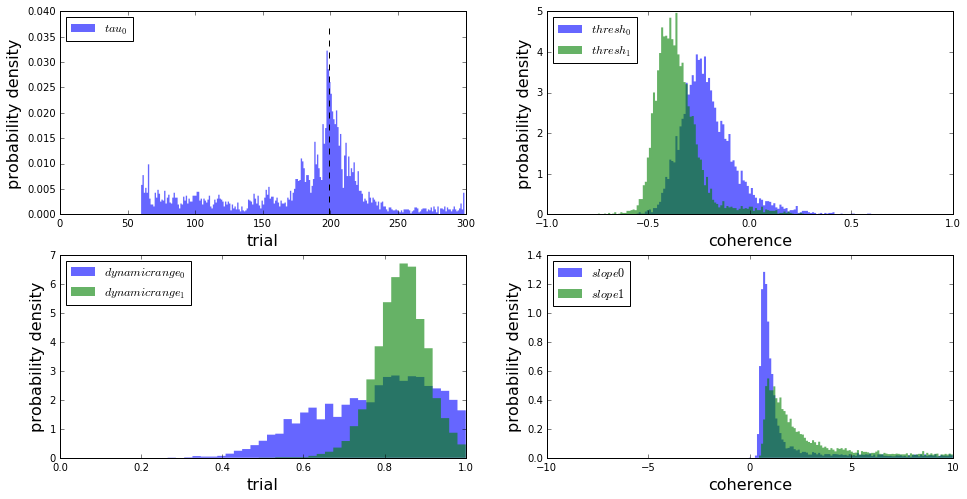

In [68]:
import scipy

plt.figure(figsize=(16,8))
plt.title('When does the rat change behavior?',fontsize=20)

plt.subplot(221)
to_plot = mcmc.trace('tau0')[:]
tau0_m = scipy.stats.mode(to_plot)[0]
plt.plot((199,199),(0,0.037),'--k')
plt.hist(to_plot,histtype='stepfilled',bins=range(0,300),alpha = 0.6,label='$ tau _0$',linewidth = 0,normed = True)
plt.legend(loc='upper left')
plt.ylabel('probability density',fontsize=16)
plt.xlabel('trial',fontsize = 16)

inds_where = np.where(to_plot==tau0_m)

plt.subplot(222)
to_plot = mcmc.trace('threshold0')[:]
thresh0_m = scipy.stats.mode(to_plot)[0]
plt.hist(to_plot,histtype='stepfilled',bins=np.linspace(-1,1,200),alpha = 0.6,label='$thresh_0$',linewidth = 0,normed = True)
to_plot = mcmc.trace('threshold1')[:]
thresh1_m = scipy.stats.mode(to_plot)[0]
plt.hist(to_plot,histtype='stepfilled',bins=np.linspace(-1,1,200),alpha = 0.6,label='$thresh_1$',linewidth = 0,normed = True)
plt.legend(loc='upper left')
plt.ylabel('probability density',fontsize=16)
plt.xlabel('coherence',fontsize = 16)

plt.subplot(223)
to_plot = mcmc.trace('amp0')[:]
amp0_m = scipy.stats.mode(to_plot)[0]

plt.hist(to_plot,histtype='stepfilled',bins=np.linspace(0,1),alpha = 0.6,label='$dynamic range_0$',linewidth = 0,normed = True)
plt.legend(loc='upper left')
plt.ylabel('probability density',fontsize=16)
plt.xlabel('trial',fontsize = 16)
to_plot = mcmc.trace('amp1')[:]
amp1_m = scipy.stats.mode(to_plot)[0]
plt.hist(to_plot,histtype='stepfilled',bins=np.linspace(0,1),alpha = 0.6,label='$dynamic range_1$',linewidth = 0,normed = True)
plt.legend(loc='upper left')
plt.ylabel('probability density',fontsize=16)
plt.xlabel('trial',fontsize = 16)

plt.subplot(224)
to_plot = mcmc.trace('slope0')[:]
slope0_m = scipy.stats.mode(to_plot)[0]

plt.hist(to_plot,histtype='stepfilled',bins=np.linspace(-10,10,200),alpha = 0.6,label='$slope0$',linewidth = 0,normed = True)
to_plot = mcmc.trace('slope1')[:]
slope1_m = scipy.stats.mode(to_plot)[0]

plt.hist(to_plot,histtype='stepfilled',bins=np.linspace(-10,10,200),alpha = 0.6,label='$slope1$',linewidth = 0,normed = True)
plt.legend(loc='upper left')
plt.ylabel('probability density',fontsize=16)
plt.xlabel('coherence',fontsize = 16)
plt.savefig('rosa0_mcmc.pdf')

In [72]:
np.where(mcmc.trace('tau0')[:]==200)

(array([  44,  114,  163,  168,  169,  222,  322,  335,  336,  348,  349,
         380,  524,  564,  572,  576,  593,  626,  627,  629,  653,  654,
         669,  715,  915,  930,  965,  971,  972,  985,  986,  987, 1347,
        1415, 1419, 1483, 1638, 1686, 1709, 1734, 1781, 1855, 1906, 1907,
        1969, 1970, 1971, 2186, 2257, 2258, 2337, 2380, 2381, 2382, 2383,
        2397, 2398, 2471, 2595, 2766, 2778, 2848, 2854, 2941, 2942, 2943,
        2958, 3063, 3083, 3095, 3120, 3121, 3156, 3157, 3271, 3428, 3444,
        3445, 3506, 3582, 3611, 3612, 3613, 3718, 3758, 3771, 3946, 3947,
        4022, 4108, 4115, 4160, 4164, 4208, 4209, 4398, 4572, 4747, 4748,
        4856, 4883, 5036, 5085, 5086, 5149, 5217, 5320, 5356, 5386, 5517,
        5518, 5519, 5520, 5521, 5522, 5523, 5524, 5525, 5612, 5613, 5800,
        5801, 5802]),)

(array([  4.,   3.,   7.,  14.,  14.,  16.,  27.,   7.,  10.,   5.]),
 array([ 0.71179091,  0.73490437,  0.75801782,  0.78113127,  0.80424473,
         0.82735818,  0.85047163,  0.87358509,  0.89669854,  0.91981199,
         0.94292545]),
 <a list of 10 Patch objects>)

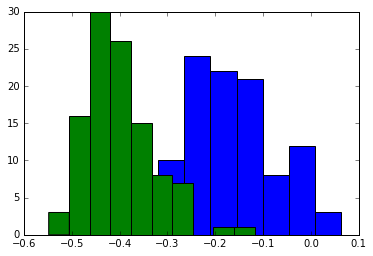

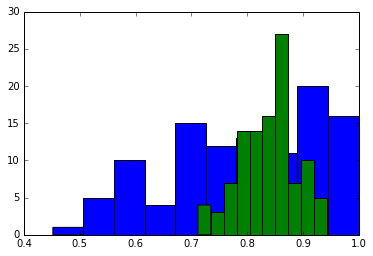

In [52]:
plt.hist(mcmc.trace('threshold0')[inds_where])
plt.hist(mcmc.trace('threshold1')[inds_where])
plt.figure()
plt.hist(mcmc.trace('amp0')[inds_where])
plt.hist(mcmc.trace('amp1')[inds_where])

-0.17367795499


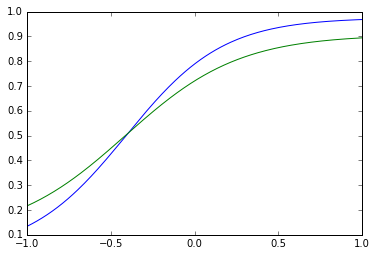

In [74]:
inds_where = 42
inds_where = 5802
print mcmc.trace('threshold0')[inds_where]

x_vals = np.linspace(-1,1,200).reshape(200,1)
y_vals = amp0_m*(1/( 1+np.exp(-4*slope0_m*(x_vals- thresh0_m)) )-0.5)+0.5
plt.plot(x_vals,y_vals)
y_vals = amp1_m*(1/( 1+np.exp(-4*slope1_m*(x_vals- thresh1_m)) )-0.5)+0.5
plt.plot(x_vals,y_vals)
plt.savefig('rosa0_mcmc_psych_curve.pdf')

In [ ]:
# this runs mcmc on the data with a shift in activity

response_data = np.ravel(data.response_right)
coherences = np.ravel(data.coherence)
unique_coherences = np.unique(coherences);

num_tau = 1

taus = pm.DiscreteUniform('taus',0,300,value=150)
slopes = pm.Uniform('slopes',-10,10)
threshs = pm.Uniform('thress',-1,1,value = 0)
amps = pm.Uniform('amps',0,1,value=0.85)

@pm.deterministic
def slope_i(assignment=assignment,slopes=slopes):
    return slopes[assignment]

@pm.deterministic
def threshs_i(assignment=assignment,threshs=threshs):
    return threshs[assignment]

@pm.deterministic
def amps_i(assignment=assignment,amps=amps):
    return amps[assignment]








observation = pm.Bernoulli("obs",coin_probs_over_time,value=response_data,observed=True)








tau_tup = ()

ll, uu = 0, len(response_data)-num_tau
ll,uu = 60,len(response_data)-num_tau-60

for k in range(num_tau):
    #tau_tup= tau_tup + (pm.DiscreteUniform('tau'+str(k),lower=ll,upper=uu,value=150),)
    tau_tup= tau_tup + (pm.Binomial('tau'+str(k),300,0.65,value=200),)
    ll,uu = tau_tup[k],uu+1
tau_tup  = tau_tup + (len(response_data),)
tau_tup = tau_tup + (10,)



slope_tup = ()
threshold_tup = ()
amp_tup = ()
for k in range(num_tau+1):
    slope_tup = slope_tup + (pm.Uniform('slope'+str(k),-10,10),)
    threshold_tup = threshold_tup + (pm.Uniform('threshold'+str(k),-1,1,value = 0),)
    amp_tup = amp_tup + (pm.Uniform('amp'+str(k),0.1,value=0.85),)


@pm.deterministic
def coin_probs_over_time(o1_=amp_tup, s_ = slope_tup, thresh_=threshold_tup,tau_ = tau_tup, uc = unique_coherences,c = coherences):
    out = np.zeros(len(c))
    
    for k in range(uc.size):
        ll,uu = 0,tau_tup[0]
        for r in range(num_tau+1):

            rr = range(ll,uu)
            these_c = np.ravel(np.where(c==uc[k]))
            
            these_c = list(set(these_c).intersection(set(rr)))
            #out[these_c] = 1/( 1+math.exp(-4*s_[r]*(uc[k]- thresh_[r])) )
            out[these_c]=o1_[r]*(1/( 1+math.exp(-4*s_[r]*(uc[k]- thresh_[r])) )-0.5)+0.5
            
            ll,uu=uu,tau_tup[r+1]
            
    return out

observation = pm.Bernoulli("obs",coin_probs_over_time,value=response_data,observed=True)



M = pm.Model(list(tau_tup)[0:num_tau]+list(amp_tup)+list(slope_tup)+list(threshold_tup)+[coin_probs_over_time,observation])
mcmc = pm.MCMC(M)
plt.title('When does the rat change behavior?',fontsize=20)
mcmc.sample(80000,40000,5)

/home/adam/anaconda2/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/adam/anaconda2/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 [-----------------100%-----------------] 10000 of 10000 complete in 4.2 sec(200, 1)
(200, 1)
0.0502431874026
 [-----------------100%-----------------] 10000 of 10000 complete in 4.7 sec(200, 1)
(200, 1)
0.332976118866


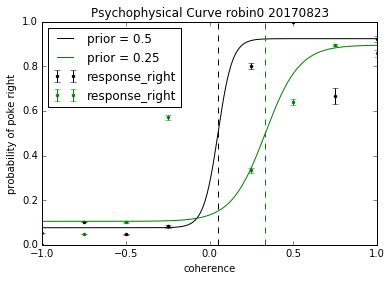

In [19]:
rat_name = 'robin0'
folder = '20170823'
file1 = glob.glob('/home/adam/Documents/DATA/RDK/Behavior_1/Box*/' + folder + '/'+rat_name+'_session1.spd')
data = load_RDK_data_from_mat_to_pandas(file1[0])
data = pd.DataFrame.from_dict(data)
data.index.name = 'trial'

# this makes psychophysical curves
data = data[150:450]
data = data.reset_index()
data.prior_right[0:120]=0.5
data.prior_right[121:]=0.25

plt.figure()
plt.title('psychophysical curves')
plt.xlabel('coherence')
plt.ylabel('probability of poke right')
for p in data.prior_right.unique():
    cc = color_cycle.next()
    
    data_p = data.loc[lambda x: x.prior_right == p] # pick out data for the given prior
    coherence_means = data_p.groupby(['coherence'],as_index=False).response_right.mean()
    
    # std of estimation for a binary variable is sqrt(p(1-p)/n)
    yerrors = np.ravel(coherence_means.apply(lambda x: x*(1-x)).response_right)
    yerrors = yerrors/np.ravel(data_p['coherence'].value_counts())
    plt.errorbar(coherence_means.coherence,coherence_means.response_right,yerr = yerrors,fmt='.',color=cc)
    
    # logistic regression to fit psychophysical curve
    #log_model = linear_model.LogisticRegression(C=1e20,max_iter=100,penalty='l2')
    #log_model.fit(X = data_p.coherence.reshape(data_p.coherence.count(),1), y = np.ravel(data_p.response_right))
    x_val,y_val,thresh = make_psych_curve_mcmc(data_p)
    print x_val.shape
    print y_val.shape
    print thresh
    
    
    # plot values psych curves
   
    plt.plot(x_val,y_val,color=cc,label ='prior = '+str(p) )
    plt.plot((thresh, thresh), (0, 1), '--',color = cc)
    plt.title('Psychophysical Curve '+rat_name+' '+folder)
    
plt.legend(loc='upper left')


In [190]:
rat_name = 'robin0'
folder = '20170823'
file1 = glob.glob('/home/adam/Documents/DATA/RDK/Behavior_1/Box*/' + folder + '/'+rat_name+'_session1.spd')
data = load_RDK_data_from_mat_to_pandas(file1[0])
data = pd.DataFrame.from_dict(data)
data.index.name = 'trial'
data = data[150:450]
data.reset_index()


In [21]:
data

,trial,coherence,prior_right,response_right,stim_right,was_correct
0,200,1.00,0.25,1,1,1
1,201,0.75,0.25,1,1,1
2,202,-1.00,0.25,0,0,1
3,203,-0.25,0.25,0,0,1
4,204,-0.50,0.25,0,0,1
5,205,-0.75,0.25,1,0,0
6,206,1.00,0.25,1,1,1
7,207,-0.50,0.25,0,0,1
8,208,-1.00,0.25,0,0,1
9,209,-0.75,0.25,1,0,0
